## Import Libraries

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm


##  Set Device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Load CIFAR-10 Dataset

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Example shape
example_data, _ = next(iter(train_loader))
print("Image shape:", example_data[0].shape)  # (3, 32, 32)

Image shape: torch.Size([3, 32, 32])


## Define VAE

In [10]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # -> 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # -> 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # -> 128x4x4
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # -> 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # -> 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # -> 3x32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.flatten(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## Define VAE Loss Function

In [11]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss


## Train the VAE

In [12]:
conv_vae = ConvVAE().to(device)

def train_vae(model, loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)

        for imgs, _ in loop:
            imgs = imgs.to(device)
            recon, mu, logvar = model(imgs)
            loss = vae_loss(recon, imgs, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {total_loss / len(loader.dataset):.4f}")

train_vae(conv_vae, train_loader, epochs=20)


Epoch [1/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/20], Avg Loss: 115.3352


Epoch [2/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/20], Avg Loss: 83.6894


Epoch [3/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/20], Avg Loss: 80.0434


Epoch [4/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/20], Avg Loss: 78.3657


Epoch [5/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/20], Avg Loss: 77.5483


Epoch [6/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/20], Avg Loss: 77.0500


Epoch [7/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/20], Avg Loss: 76.5914


Epoch [8/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/20], Avg Loss: 76.1251


Epoch [9/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/20], Avg Loss: 75.9356


Epoch [10/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/20], Avg Loss: 75.6084


Epoch [11/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/20], Avg Loss: 75.4409


Epoch [12/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/20], Avg Loss: 75.2667


Epoch [13/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/20], Avg Loss: 75.0879


Epoch [14/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/20], Avg Loss: 75.0211


Epoch [15/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/20], Avg Loss: 74.9196


Epoch [16/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/20], Avg Loss: 74.7767


Epoch [17/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/20], Avg Loss: 74.7433


Epoch [18/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/20], Avg Loss: 74.6786


Epoch [19/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/20], Avg Loss: 74.5293


Epoch [20/20]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/20], Avg Loss: 74.5273


## Reconstruct Some CIFAR-10 Images

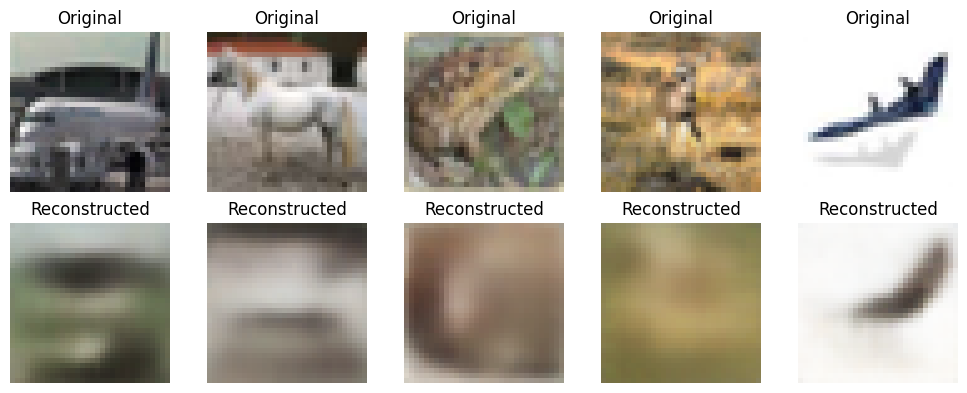

In [13]:
conv_vae.eval()
with torch.no_grad():
    imgs, _ = next(iter(train_loader))
    imgs = imgs[:5].to(device)
    recon_imgs, _, _ = conv_vae(imgs)
    recon_imgs = recon_imgs.cpu()

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(imgs[i].cpu().numpy(), (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(np.transpose(recon_imgs[i].numpy(), (1, 2, 0)))
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


##  Generate 5 Images from N(μ=5, σ²=1)

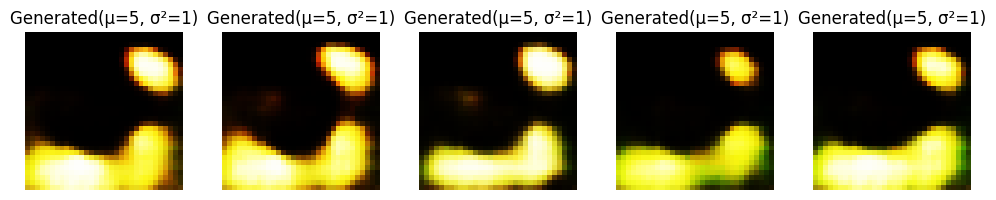

In [15]:
latent_dim = conv_vae.latent_dim
noise = torch.randn((5, latent_dim)) * 1 + 5
noise = noise.to(device)

with torch.no_grad():
    gen_imgs = conv_vae.decode(noise)

gen_imgs = gen_imgs.cpu()

plt.figure(figsize=(10, 2))
for i, img in enumerate(gen_imgs):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title("Generated(μ=5, σ²=1)")
    plt.axis('off')
plt.tight_layout()
plt.show()
